In [3]:
!pip install torchsummary

In [28]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchsummary import summary

# Подготовка тренировочного датасета

In [5]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: Tesla P100-PCIE-16GB
PyTorch CUDA version: 12.3
Tensor device: cuda:0


In [6]:
device

device(type='cuda')

In [7]:
pd.read_csv('/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/train_answers.csv').head()

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6


In [8]:
categories = pd.read_csv('/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/activity_categories.csv')

categories.head()

,id,category
0,0,sports
1,1,inactivity quiet/light
2,2,miscellaneous
3,3,occupation
4,4,water activities


In [9]:
id_to_category = dict(zip(categories['id'], categories['category']))

In [10]:
class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        """
        img_dir: Папка с изображениями (В моем случае, 'drive/MyDrive/DataSets/human_poses_data/img_train').
        csv_file: Путь к таблице с метками (например, 'train_answers.csv').
        transform: Трансформации для предобработки изображений.
        """
        self.img_dir = img_dir
        self.labels = pd.read_csv(csv_file)  # Загружаем таблицу меток
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Достаем имя изображения и метку
        img_id = self.labels.iloc[idx, 0]  # img_id (имя изображения)
        label = self.labels.iloc[idx, 1]  # target_feature (метка)

        # Загружаем изображение
        img_path = os.path.join(self.img_dir, str(img_id)+'.jpg')
        image = Image.open(img_path).convert("RGB")  # Убедимся, что изображение в RGB

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label


In [11]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [12]:
RANDOM_SEED = 52
torch.manual_seed(RANDOM_SEED)

In [13]:
print(f"Available CPU cores: {os.cpu_count()}")

Available CPU cores: 4


In [14]:
dataset = HumanPoseDataset(
    img_dir='/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/img_train',
    csv_file='/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/train_answers.csv',
    transform=transform
)

train_dataset, val_dataset = random_split(dataset, [int(0.9*len(dataset)), len(dataset) - int(0.9*len(dataset))])

In [15]:
def show_images_row(images, labels, size=(2, 2)):
    """
    Параметры:
    - images: список тензоров изображений
    - labels: список меток
    - size: кортеж (ширина, высота) изображения
    """
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(size[0] * num_images, size[1]))
    if num_images == 1:
        axes = [axes]  # Если одно изображение, делаем axes списком

    for img, label, ax in zip(images, labels, axes):
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f'Label: {id_to_category[label]}')
        ax.axis('off')  # Убираем оси

    plt.tight_layout()
    plt.show()

In [16]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

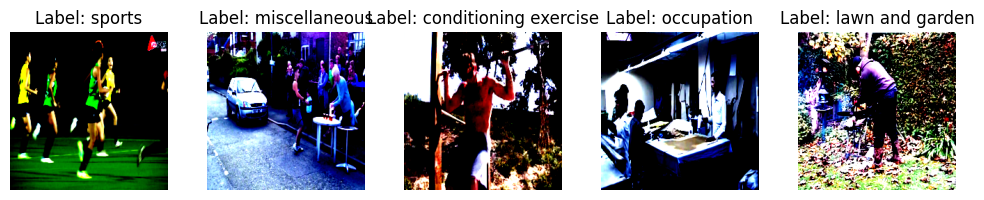

In [17]:
# Получить батч данных
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Вывести первые 5 изображений в одну строку
show_images_row(images[:5], [label.item() for label in labels[:5]], size=(2, 2))

# Архитектуры

In [18]:
class AlexNetArtem(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetArtem, self).__init__()
        self.num_classes = num_classes
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=96, out_channels=256, kernel_size=5, padding=2
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=256, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(
                in_features=4096, out_features=self.num_classes
            ),
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [19]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)
        return out

class YaroslavResNet(nn.Module):
    def __init__(self, block, layers, num_classes=20):
        super(YaroslavResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def custom_resnet18(num_classes=20):
    return YaroslavResNet(ResidualBlock, [2, 2, 2, 2], num_classes)

In [21]:
len(id_to_category)

20

In [22]:
summary(custom_resnet18().to(device), (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]          36,864
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
    ResidualBlock-11           [-1, 64, 57, 57]               0
           Conv2d-12           [-1, 64, 57, 57]          36,864
      BatchNorm2d-13           [-1, 64, 57, 57]             128
             ReLU-14           [-1, 64,

# Обучение

In [23]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
import logging
import tqdm

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [24]:
model = custom_resnet18().to(device)

In [25]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # добавил weight_decay
# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

In [26]:
import time

time.localtime()

time.struct_time(tm_year=2024, tm_mon=12, tm_mday=7, tm_hour=13, tm_min=40, tm_sec=11, tm_wday=5, tm_yday=342, tm_isdst=0)

In [29]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)  # Снижение LR по плато
# или можно использовать StepLR
# scheduler = StepLR(optimizer, step_size=7, gamma=0.1)  # Снижение LR каждые 7 эпох

# Определяем одну итерацию обучения (тренировочный шаг)
def train_step(engine, batch):
    model.train()  # Переводим модель в режим обучения
    images, labels = batch
    images, labels = images.to(device), labels.to(device)  # Перенос данных на устройство (CPU/GPU)
    optimizer.zero_grad()  # Обнуляем градиенты
    outputs = model(images)  # Прямой проход (forward pass)
    loss = criterion(outputs, labels)  # Вычисляем функцию потерь
    loss.backward()  # Вычисляем градиенты
    optimizer.step()  # Обновляем параметры модели
    return {"loss": loss.item(), "outputs": outputs, "labels": labels}

# Определяем одну итерацию валидации
def val_step(engine, batch):
    model.eval()  # Переводим модель в режим оценки
    with torch.no_grad():  # Отключаем вычисление градиентов (ускоряет выполнение и экономит память)
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Прямой проход
        return outputs, labels  # Возвращаем предсказания и истинные метки

# Создаём движки (engines) для тренировки и валидации
trainer = Engine(train_step)  # Движок для обучения
evaluator = Engine(val_step)  # Движок для валидации

# Добавляем метрики для обучения
train_loss = Loss(criterion, output_transform=lambda x: (x["outputs"], x["labels"]))
train_accuracy = Accuracy(output_transform=lambda x: (x["outputs"], x["labels"]))
train_loss.attach(trainer, "loss")  # Привязываем метрику функции потерь к тренеру
train_accuracy.attach(trainer, "accuracy")  # Привязываем метрику точности к тренеру

# Добавляем метрики для валидации
Accuracy().attach(evaluator, "accuracy")  # Точность
Loss(criterion).attach(evaluator, "loss")  # Функция потерь

# Прогресс-бар для отображения статуса обучения
ProgressBar().attach(trainer)
ProgressBar().attach(evaluator)

cur_time = time.localtime()
path_suf = '_' + str(cur_time.tm_mday) + '_' + str(cur_time.tm_mon) + '_' + str(cur_time.tm_hour) + '_' + str(cur_time.tm_min)

# Настройка логирования
log_dir = "./train_info/logs" + path_suf
os.makedirs(log_dir, exist_ok=True)  # Создаём директорию для логов, если её нет
logging.basicConfig(
    filename="training.log",  # Файл для записи логов
    level=logging.INFO,  # Уровень логирования
    format="%(asctime)s - %(message)s",  # Формат записей
)
logger = logging.getLogger()  # Создаём логгер

# Создаём DataFrame для метрик
metrics_path = os.path.join(log_dir, "metrics.csv")
if os.path.exists(metrics_path):
    metrics_df = pd.read_csv(metrics_path)  # Загружаем существующие метрики, если файл есть
else:
    metrics_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

# Настроим сохранение модели при лучших результатах
to_save = {"model": model, "optimizer": optimizer, "trainer": trainer}
handler = Checkpoint(
    to_save,
    DiskSaver("./train_info/checkpoints" + path_suf, create_dir=True, require_empty=False, atomic=False),
    n_saved=3,  # Сохраняем только последние 3 чекпоинта
    filename_prefix="best",
    score_function=lambda engine: engine.state.metrics["accuracy"],  # Критерий выбора "лучшей" модели
    score_name="val_accuracy",  # Название критерия
    global_step_transform=global_step_from_engine(trainer),
)

# Добавляем событие для логирования и сохранения метрик после каждой эпохи
@trainer.on(Events.EPOCH_COMPLETED)
def log_and_save_metrics(engine):
    # Получаем метрики для тренировки
    train_metrics = engine.state.metrics
    train_loss = train_metrics["loss"]
    train_accuracy = train_metrics["accuracy"]
    
    # Запускаем валидацию
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_accuracy = val_metrics["accuracy"]
    
    # Логируем метрики
    logger.info(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Сохраняем метрики в DataFrame и записываем в CSV
    global metrics_df
    metrics_df = pd.concat(
        [metrics_df, pd.DataFrame({
            "Epoch": [engine.state.epoch],
            "Train Loss": [train_loss],
            "Train Accuracy": [train_accuracy],
            "Validation Loss": [val_loss],
            "Validation Accuracy": [val_accuracy],
        })],
        ignore_index=True
    )
    metrics_df.to_csv(metrics_path, index=False)
    
    # Сохраняем модель
    handler(evaluator)
    # Обновляем learning rate
    scheduler.step(val_loss)  # Для ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Если аугментация не поможет бороться с переобучением, то пробуем:
1) Гиперпараметр weight_decay=1e-4
2) Снижение lr:
    torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3) # по плато
    torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # по шагам

In [30]:
trainer.run(train_loader, max_epochs=100)

# Полный output обучения можно посмотреть в traning.log

[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 1: Train Loss: 2.3580, Train Accuracy: 0.2525, Validation Loss: 2.2835, Validation Accuracy: 0.2587


/tmp/ipykernel_141/1887167339.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat(


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 2: Train Loss: 2.1529, Train Accuracy: 0.3062, Validation Loss: 2.2835, Validation Accuracy: 0.2660


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 3: Train Loss: 2.0514, Train Accuracy: 0.3399, Validation Loss: 2.1843, Validation Accuracy: 0.3048


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 4: Train Loss: 1.9689, Train Accuracy: 0.3606, Validation Loss: 2.0159, Validation Accuracy: 0.3355


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 5: Train Loss: 1.9177, Train Accuracy: 0.3824, Validation Loss: 2.2434, Validation Accuracy: 0.2951


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 6: Train Loss: 1.8272, Train Accuracy: 0.4061, Validation Loss: 1.8977, Validation Accuracy: 0.3840


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 7: Train Loss: 1.7664, Train Accuracy: 0.4270, Validation Loss: 1.9878, Validation Accuracy: 0.3654


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 8: Train Loss: 1.7003, Train Accuracy: 0.4467, Validation Loss: 1.8407, Validation Accuracy: 0.4188


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 9: Train Loss: 1.6232, Train Accuracy: 0.4750, Validation Loss: 1.8257, Validation Accuracy: 0.4099


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 10: Train Loss: 1.5619, Train Accuracy: 0.4971, Validation Loss: 1.7888, Validation Accuracy: 0.4058


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 11: Train Loss: 1.4550, Train Accuracy: 0.5284, Validation Loss: 1.7739, Validation Accuracy: 0.4454


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 12: Train Loss: 1.3557, Train Accuracy: 0.5655, Validation Loss: 1.7397, Validation Accuracy: 0.4535


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 13: Train Loss: 1.2252, Train Accuracy: 0.6007, Validation Loss: 1.6495, Validation Accuracy: 0.4673


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 14: Train Loss: 1.0937, Train Accuracy: 0.6454, Validation Loss: 1.6332, Validation Accuracy: 0.5053


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 15: Train Loss: 0.9316, Train Accuracy: 0.7023, Validation Loss: 1.6874, Validation Accuracy: 0.5133


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 16: Train Loss: 0.7609, Train Accuracy: 0.7533, Validation Loss: 1.7602, Validation Accuracy: 0.5109


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 17: Train Loss: 0.5670, Train Accuracy: 0.8175, Validation Loss: 2.1710, Validation Accuracy: 0.4729


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 18: Train Loss: 0.4359, Train Accuracy: 0.8581, Validation Loss: 1.9069, Validation Accuracy: 0.5117


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 19: Train Loss: 0.1824, Train Accuracy: 0.9533, Validation Loss: 1.5872, Validation Accuracy: 0.5829


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 20: Train Loss: 0.0853, Train Accuracy: 0.9880, Validation Loss: 1.5994, Validation Accuracy: 0.5918


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 21: Train Loss: 0.0561, Train Accuracy: 0.9947, Validation Loss: 1.6385, Validation Accuracy: 0.5901


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 22: Train Loss: 0.0423, Train Accuracy: 0.9967, Validation Loss: 1.6462, Validation Accuracy: 0.5901


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 23: Train Loss: 0.0319, Train Accuracy: 0.9981, Validation Loss: 1.6372, Validation Accuracy: 0.5909


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 24: Train Loss: 0.0250, Train Accuracy: 0.9992, Validation Loss: 1.6655, Validation Accuracy: 0.5885


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 25: Train Loss: 0.0249, Train Accuracy: 0.9993, Validation Loss: 1.6504, Validation Accuracy: 0.5926


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 26: Train Loss: 0.0225, Train Accuracy: 0.9990, Validation Loss: 1.6555, Validation Accuracy: 0.5934


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 27: Train Loss: 0.0217, Train Accuracy: 0.9989, Validation Loss: 1.6647, Validation Accuracy: 0.5901


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 28: Train Loss: 0.0230, Train Accuracy: 0.9994, Validation Loss: 1.6712, Validation Accuracy: 0.5942


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 29: Train Loss: 0.0227, Train Accuracy: 0.9994, Validation Loss: 1.6570, Validation Accuracy: 0.5909


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 30: Train Loss: 0.0224, Train Accuracy: 0.9987, Validation Loss: 1.6683, Validation Accuracy: 0.5942


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 31: Train Loss: 0.0214, Train Accuracy: 0.9990, Validation Loss: 1.6705, Validation Accuracy: 0.5918


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 32: Train Loss: 0.0208, Train Accuracy: 0.9994, Validation Loss: 1.6654, Validation Accuracy: 0.5877


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 33: Train Loss: 0.0207, Train Accuracy: 0.9993, Validation Loss: 1.6610, Validation Accuracy: 0.5950


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 34: Train Loss: 0.0223, Train Accuracy: 0.9992, Validation Loss: 1.6636, Validation Accuracy: 0.5950


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 35: Train Loss: 0.0213, Train Accuracy: 0.9995, Validation Loss: 1.6683, Validation Accuracy: 0.5958


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 36: Train Loss: 0.0208, Train Accuracy: 0.9996, Validation Loss: 1.6665, Validation Accuracy: 0.5901


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 37: Train Loss: 0.0218, Train Accuracy: 0.9993, Validation Loss: 1.6552, Validation Accuracy: 0.5893


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 38: Train Loss: 0.0215, Train Accuracy: 0.9991, Validation Loss: 1.6530, Validation Accuracy: 0.5918


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 39: Train Loss: 0.0210, Train Accuracy: 0.9996, Validation Loss: 1.6640, Validation Accuracy: 0.5918


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 40: Train Loss: 0.0215, Train Accuracy: 0.9996, Validation Loss: 1.6622, Validation Accuracy: 0.5918


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 41: Train Loss: 0.0207, Train Accuracy: 0.9996, Validation Loss: 1.6771, Validation Accuracy: 0.5909


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 42: Train Loss: 0.0212, Train Accuracy: 0.9991, Validation Loss: 1.6761, Validation Accuracy: 0.5901


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 43: Train Loss: 0.0210, Train Accuracy: 0.9992, Validation Loss: 1.6738, Validation Accuracy: 0.5909


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 44: Train Loss: 0.0225, Train Accuracy: 0.9989, Validation Loss: 1.6658, Validation Accuracy: 0.5893


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 45: Train Loss: 0.0218, Train Accuracy: 0.9993, Validation Loss: 1.6707, Validation Accuracy: 0.5934


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 46: Train Loss: 0.0216, Train Accuracy: 0.9996, Validation Loss: 1.6672, Validation Accuracy: 0.5918


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 47: Train Loss: 0.0210, Train Accuracy: 0.9994, Validation Loss: 1.6843, Validation Accuracy: 0.5926


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 48: Train Loss: 0.0210, Train Accuracy: 0.9993, Validation Loss: 1.6688, Validation Accuracy: 0.5926


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 49: Train Loss: 0.0220, Train Accuracy: 0.9996, Validation Loss: 1.6651, Validation Accuracy: 0.5942


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 50: Train Loss: 0.0203, Train Accuracy: 0.9994, Validation Loss: 1.6699, Validation Accuracy: 0.5901


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 51: Train Loss: 0.0209, Train Accuracy: 0.9994, Validation Loss: 1.6632, Validation Accuracy: 0.5966


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 52: Train Loss: 0.0216, Train Accuracy: 0.9993, Validation Loss: 1.6662, Validation Accuracy: 0.5901


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 53: Train Loss: 0.0212, Train Accuracy: 0.9999, Validation Loss: 1.6640, Validation Accuracy: 0.5909


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 54: Train Loss: 0.0219, Train Accuracy: 0.9992, Validation Loss: 1.6689, Validation Accuracy: 0.5909


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 55: Train Loss: 0.0211, Train Accuracy: 0.9996, Validation Loss: 1.6668, Validation Accuracy: 0.5918


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 56: Train Loss: 0.0214, Train Accuracy: 0.9995, Validation Loss: 1.6574, Validation Accuracy: 0.5966


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 57: Train Loss: 0.0219, Train Accuracy: 0.9992, Validation Loss: 1.6697, Validation Accuracy: 0.5885


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 58: Train Loss: 0.0217, Train Accuracy: 0.9995, Validation Loss: 1.6587, Validation Accuracy: 0.5909


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 59: Train Loss: 0.0225, Train Accuracy: 0.9987, Validation Loss: 1.6719, Validation Accuracy: 0.5885


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 60: Train Loss: 0.0219, Train Accuracy: 0.9989, Validation Loss: 1.6648, Validation Accuracy: 0.5869


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 61: Train Loss: 0.0218, Train Accuracy: 0.9991, Validation Loss: 1.6742, Validation Accuracy: 0.5885


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 62: Train Loss: 0.0216, Train Accuracy: 0.9994, Validation Loss: 1.6696, Validation Accuracy: 0.5901


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 63: Train Loss: 0.0216, Train Accuracy: 0.9992, Validation Loss: 1.6661, Validation Accuracy: 0.5918


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 64: Train Loss: 0.0212, Train Accuracy: 0.9992, Validation Loss: 1.6616, Validation Accuracy: 0.5901


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 65: Train Loss: 0.0221, Train Accuracy: 0.9992, Validation Loss: 1.6695, Validation Accuracy: 0.5926


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 66: Train Loss: 0.0208, Train Accuracy: 0.9996, Validation Loss: 1.6580, Validation Accuracy: 0.5966


[1/174]   1%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 67: Train Loss: 0.0219, Train Accuracy: 0.9991, Validation Loss: 1.6633, Validation Accuracy: 0.5966


[1/174]   1%|           [00:00<?]

KeyboardInterrupt: 

Когда выберем модель и сделаем аугментацию можно подгонять гиперпараметры оптюной

# Просмотр результатов обучения

Перед просмотром результатов обучения, убедитесь, что запускали ячеки из папок 'Подготовка тренировочного датасета' и 'Архитектуры'

In [31]:
import pandas as pd
from torch.optim import Adam
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine

In [32]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

<Axes: >

<Figure size 640x480 with 0 Axes>

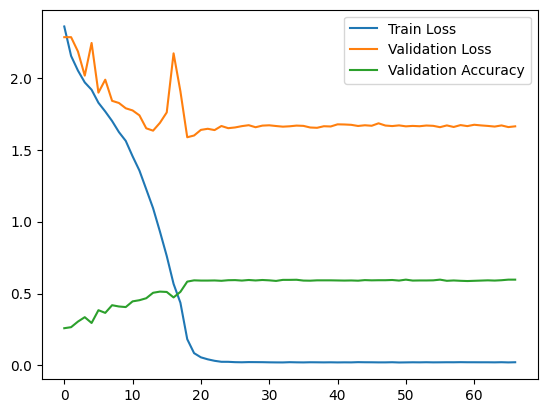

In [51]:
metrics_path = "/kaggle/working/train_info/logs_7_12_13_40/metrics.csv"

metrics = pd.read_csv(metrics_path)

plt.figure()
metrics[['Train Loss', 'Validation Loss', 'Validation Accuracy']].plot()

In [35]:
from ignite.handlers import Checkpoint
import torch

In [36]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: Tesla P100-PCIE-16GB
PyTorch CUDA version: 12.3
Tensor device: cuda:0


In [38]:
model = custom_resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [47]:
checkpoint_path = "/kaggle/working/train_info/checkpoints_7_12_13_40/best_checkpoint_56_val_accuracy=0.5966.pt"

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

model.eval()

start_epoch = checkpoint["trainer"]['iteration'] / checkpoint["trainer"]['epoch_length']
start_epoch

/tmp/ipykernel_141/732575421.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


56.0

In [48]:
checkpoint['trainer']

OrderedDict([('epoch_length', 174), ('max_epochs', 100), ('iteration', 9744)])

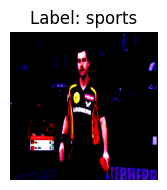

sports


In [49]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_images_row([images[0]], [label.item() for label in labels[:5]], size=(2, 2))

probabilities = torch.softmax(model(images[0].unsqueeze(0).to(device)), dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print(id_to_category[predicted_class])

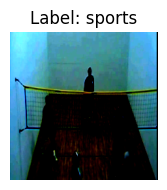

sports


In [45]:
dataiter = iter(DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0))
images, labels = next(dataiter)

show_images_row([images[0]], [label.item() for label in labels[:5]], size=(2, 2))

probabilities = torch.softmax(model(images[0].unsqueeze(0).to(device)), dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print(id_to_category[predicted_class])

In [50]:
from ignite.metrics import Accuracy
from ignite.metrics import Precision, Recall, Fbeta, Accuracy

# Функция инференса для вычисления метрик
def inference_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        return outputs, labels

# Создаём Engine для инференса
evaluator = Engine(inference_step)

# Добавляем метрику Accuracy
accuracy = Accuracy()
precision = Precision(average=True)
recall = Recall(average=True)
f1 = Fbeta(beta=1.0, average=True)

accuracy.attach(evaluator, "accuracy")
precision.attach(evaluator, "precision")
recall.attach(evaluator, "recall")
f1.attach(evaluator, "f1")

pbar = ProgressBar(persist=True)
pbar.attach(evaluator)

# Оценка на валидационном датасете
state = evaluator.run(val_loader)

print(f"Validation Accuracy: {state.metrics['accuracy']:.4f}")
print(f"Validation Precision: {state.metrics['precision']:.4f}")
print(f"Validation Recall: {state.metrics['recall']:.4f}")
print(f"Validation F1 Score: {state.metrics['f1']:.4f}")

[1/20]   5%|5          [00:00<?]

Validation Accuracy: 0.5966
Validation Precision: 0.4646
Validation Recall: 0.4287
Validation F1 Score: 0.4412
